In [6]:
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt
import torch
import copy
import os
import torchvision.transforms.v2 as transforms
from imutils import face_utils
from PIL import Image


In [2]:
import os
import forest

# from forest.filtering_defenses import get_defense
from forest.utils import write, set_random_seed
from forest.consts import BENCHMARK, NUM_CLASSES
torch.backends.cudnn.benchmark = BENCHMARK

# Parse input arguments
args = forest.options().parse_args()
args.dataset = os.path.join('datasets', args.dataset)
args.exp_name = 'test_face_extractor'
args.trigger = 'sunglasses'
args.alpha = 0.1
args.beta = 0.0
args.poisonkey = '1-6'

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=args.devices

if args.system_seed != None:
    set_random_seed(args.system_seed)

if args.exp_name is None:
    exp_num = len(os.listdir(os.path.join(os.getcwd(), 'outputs'))) + 1
    args.exp_name = f'exp_{exp_num}'

args.output = f'outputs/{args.exp_name}/{args.recipe}/{args.scenario}/{args.trigger}/{args.net[0].upper()}/{args.poisonkey}_{args.scenario}_{args.trigger}_{args.alpha}_{args.beta}_{args.attackoptim}_{args.attackiter}.txt'

os.makedirs(os.path.dirname(args.output), exist_ok=True)
open(args.output, 'w').close() # Clear the output files

torch.cuda.empty_cache()
if args.deterministic:
    forest.utils.set_deterministic()
    
setup = forest.utils.system_startup(args) # Set up device and torch data type

model = forest.Victim(args, num_classes=NUM_CLASSES, setup=setup) # Initialize model and loss_fn
data = forest.Kettle(args, model.defs.batch_size, model.defs.augmentations,
                        model.defs.mixing_method, setup=setup) # Set up trainloader, validloader, poisonloader, poison_ids, trainset/poisonset/source_testset
witch = forest.Witch(args, setup=setup)

data.select_poisons(model)

Saturday, 10. February 2024 01:00PM
------------------ Currently evaluating gradient-matching ------------------
Namespace(EPSILON=1e-07, ablation=1.0, alpha=0.1, atk_succ_threshold=99.0, attack_mode='all2one', attackiter=250, attackoptim='signAdam', backdoor_finetuning=False, batch_size=64, beta=0.0, cache_dataset=False, centreg=0, checkpoints='../../checkpoints/', clean_budget=0.2, clean_grad=False, constrain_perturbation=False, cost_multiplier=2, data_aug='default', dataset='datasets/Facial_recognition_crop_partial', defend_features_only=False, defense='', defense_set='testset', defense_sources=None, defense_steps=None, defense_strength=None, defense_type=None, deterministic=False, devices='0,1,2,3', digital_trigger=False, digital_trigger_path='digital_triggers', disable_adaptive_attack=True, dryrun=False, early_stop=True, early_stop_patience=10, early_stop_threshold=99.0, ensemble=1, eps=8, exp_name='test_face_extractor', f='/home/ubuntu/.local/share/jupyter/runtime/kernel-v2-1693V

In [8]:
class FaceDetector:
    def __init__(self, args, dataset=None, patch_trigger=False):
        """
        dataset: Poisoned dataset
        trigger: Trigger name
        """
        self.landmark_detector = dlib.cnn_face_detection_model_v1('landmarks/mmod_human_face_detector.dat')
        self.landmark_predictor_1 = dlib.shape_predictor('landmarks/shape_predictor_68_face_landmarks.dat')
        self.landmark_predictor_2 = dlib.shape_predictor('landmarks/shape_predictor_81_face_landmarks.dat')
        self.args = args
        
        if patch_trigger:
            self.patch_trigger = True
            trigger_path = os.path.join('digital_triggers', self.args.trigger) + '.png'
            self.transform = transforms.Compose([
                        transforms.ToImageTensor(),
                        transforms.ConvertImageDtype(),
                    ])
            self.trigger_img = np.array(Image.open(trigger_path))
            
        if dataset is not None:
            self.dataset = dataset
            self.dataset_landmarks = self.get_dataset_overlays()

    def get_landmarks(self, img):
        img_rescale = (img * 255.0).to(torch.uint8).permute(1,2,0).numpy()
        facebox = self.landmark_detector(img_rescale, 1)
        
        if len(facebox) == 0:
            return np.array([])
        
        landmarks_1 = self.landmark_predictor_1(img_rescale, facebox[0].rect)
        landmarks_2 = self.landmark_predictor_2(img_rescale, facebox[0].rect)
        shape_1 = face_utils.shape_to_np(landmarks_1)
        shape_2 = face_utils.shape_to_np(landmarks_2)

        shape = np.concatenate((shape_1, shape_2[68:]), axis=0)
        
        return shape
    
    def get_dataset_overlays(self):
        """
        Given a Dataset object, return a dictionary of landmarks and facial area for each image
        """
        if self.args.constrain_perturbation:
            self.dataset_face_overlay = torch.zeros((len(self.dataset), 224, 224))
        if self.patch_trigger != None:
            self.trigger_mask = torch.zeros((len(self.dataset), 4, 224, 224)) #4 as we have alpha layer
        
        for idx, (img, _, image_id) in enumerate(self.dataset):
            landmarks = self.get_landmarks(img)
            
            if len(landmarks) == 0:
                print('Faulty image: ', idx)
                if self.args.constrain_perturbation:
                    self.dataset_face_overlay[idx] = torch.ones((224, 224))
                
                if self.patch_trigger != None:
                    new_height = int(self.trigger_img.shape[0] * 50 / self.trigger_img.shape[1])
                    resize_transform = transforms.Resize((new_height, 50))
                    resized_image = resize_transform(self.trigger_img)
                    black_frame = torch.zeros([3, 224, 224], dtype=torch.float32)  # 3 channels for RGB
                    top_offset = (224 - new_height) // 2
                    left_offset = (224 - 50) // 2
                    black_frame[:, top_offset:top_offset+new_height, left_offset:left_offset+50] = resized_image
                    self.trigger_mask[idx] = black_frame
            else: 
                if self.args.constrain_perturbation:
                    mask = np.zeros((224, 224))
                    bound = [landmarks[i] for i in range(len(landmarks)) if i < 17 or i > 67]
                    routes = np.asarray([bound[i] for i in range(17)] + [bound[27], bound[23], bound[28], bound[22], bound[21], bound[29], bound[20], bound[19], bound[18], bound[17], bound[25], bound[24], bound[26]])
                    mask = torch.tensor(cv2.fillConvexPoly(mask, routes, 1)).to(torch.bool)
                    self.dataset_face_overlay[idx] = mask
                    
                if self.patch_trigger != None:
                    self.trigger_mask[idx] = self.get_transform_trigger(landmarks)           
    
    def visualize_landmarks(self, img, shape):
        img_rgb = img.detach().clone().permute(1,2,0).numpy()
        
        for idx, (x,y) in enumerate(shape):
            cv2.circle(img_rgb, (x, y), 1, (0, 255, 0), -1)
            cv2.putText(img_rgb, str(idx), (x+2, y), cv2.FONT_HERSHEY_DUPLEX, 0.2, (0, 255, 0), 1)
        
        plt.figure(figsize=(8,8))
        plt.imshow(img_rgb)
        
    def get_position(self, landmarks):
        sun_h, sun_w, _ = self.trigger_img.shape
        top_nose = np.asarray([landmarks[27][0], landmarks[27][1]])
        if self.args.trigger == 'sunglasses':         
            top_left = np.asarray([landmarks[2][0], landmarks[19][1]])
            top_right = np.asarray([landmarks[14][0], landmarks[24][1]])
            if abs(top_left[0] - top_nose[0]) > abs(top_right[0] - top_nose[0]):
                diff = abs(top_left[0] - top_nose[0]) - abs(top_right[0] - top_nose[0])
                top_right[0] = min(top_right[0] + diff // 2, 223)
                top_left[0] += diff // 2
            else:
                diff = abs(top_right[0] - top_nose[0]) - abs(top_left[0] - top_nose[0])
                top_right[0] -= diff // 2
                top_left[0] = min(top_left[0] - diff // 2, 223)
            
            # calculate new width and height, moving distance for adjusting sunglasses
            width = np.linalg.norm(top_left - top_right)
            scale = width / sun_w
            height = int(sun_h * scale)
            
        elif self.args.trigger == 'white_facemask':
            top_left = np.asarray([landmarks[1][0], landmarks[28][1]])
            top_right = np.asarray([landmarks[15][0], landmarks[28][1]])
            height = abs(landmarks[8][1] - landmarks[0][1]) # For facemask
        
        elif self.args.trigger == 'real_beard':
            top_left = np.asarray([landmarks[48][0]-5, landmarks[33][1]])
            top_right = np.asarray([landmarks[54][0]+5, landmarks[33][1]])
            height = abs(landmarks[33][1] - landmarks[8][1]) # For real_beard
            
        elif self.args.trigger == 'red_headband':
            top_left = np.asarray([landmarks[0][0], landmarks[69][1]])
            top_right = np.asarray([landmarks[16][0], landmarks[72][1]])
            
            width = np.linalg.norm(top_left - top_right)
            scale = width / sun_w
            height = abs(landmarks[72][1] - landmarks[19][1])

        unit = (top_left - top_right) / np.linalg.norm(top_left - top_right)

        perpendicular_unit = np.asarray([unit[1], -unit[0]])

        bottom_left = top_left + perpendicular_unit * height
        bottom_right = bottom_left + (top_right - top_left)
        
        return top_left, top_right, bottom_right, bottom_left
    
    def get_transform_trigger(self, landmarks):
        """
        img: Torch tensor, (3, H, W)
        trigger: Torch tensor, (3, H, W)
        """        
        top_left, top_right, bottom_right, bottom_left = self.get_position(landmarks)

        dst_points = np.asarray([
                top_left, 
                top_right,
                bottom_right,
                bottom_left], dtype=np.float32)

        src_points = np.asarray([
            [0, 0],
            [self.trigger_img.shape[1] - 1, 0],
            [self.trigger_img.shape[1] - 1, self.trigger_img.shape[0] - 1],
            [0, self.trigger_img.shape[0] - 1]], dtype=np.float32)
        
        M, _ = cv2.findHomography(src_points, dst_points)
        transformed_trigger = cv2.warpPerspective(self.trigger_img, M, (224, 224), None, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
        return self.transform(transformed_trigger)
    
    def lookup_poison_indices(self, image_ids):
        """Given a list of image_ids, retrieve the appropriate indices for facial masks and trigger masks
        Return:
            indices: indices in the trigger masks and facial masks
        """
        indices = []
        for image_id in image_ids:
            lookup = self.indices_lookup.get(image_id)
            indices.append(lookup)

        return torch.tensor(indices, dtype=torch.long)
    
    def patch_inputs(self, inputs, batch_positions, poison_slices):
        alpha_trigger_masks = self.trigger_mask[poison_slices, 3, ...].bool() * self.args.opacity # [N, 224, 224] mask
        alpha_inputs_masks = 1.0 - alpha_trigger_masks
        for depth in range(0, 3):  
            inputs[batch_positions, depth, ...] =  (
                inputs[batch_positions, depth, ...] * alpha_inputs_masks + 
                (self.trigger_mask[poison_slices, depth, ...] * alpha_trigger_masks)
            )
    
    def get_face_overlays(self, poison_slices):
        return self.dataset_face_overlay[poison_slices]

In [9]:
poisonset = data.poisonset
args.constrain_perturbation = True
face_detector = FaceDetector(args, dataset=poisonset, patch_trigger=True)

In [10]:
inputs, labels, ids = next(iter(data.poisonloader))

inputs = inputs.to(**setup)
labels = labels.to(dtype=torch.long, device=setup['device'], non_blocking=True)

poison_slices, batch_positions = data.lookup_poison_indices(ids)
face_detector.patch_inputs(inputs, batch_positions, poison_slices)
        

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [21]:
face_detector.dataset_face_overlay[0]

AttributeError: 'FaceDetector' object has no attribute 'dataset_face_overlay'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


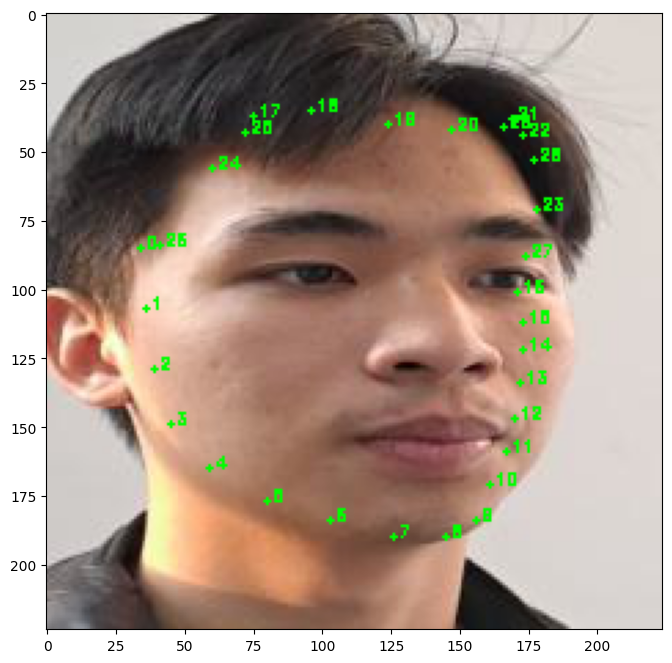

In [47]:
bound = [shape[i] for i in range(len(shape)) if i < 17 or i > 67]
face_detector.visualize_landmarks(image, bound)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


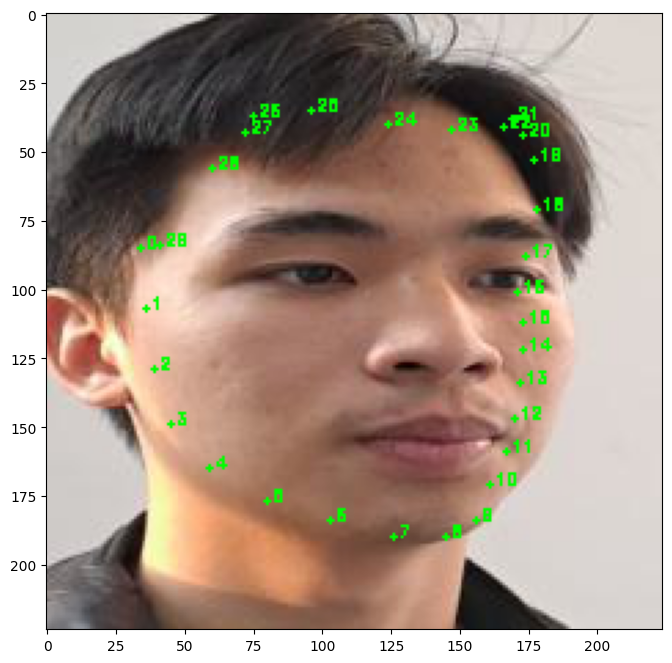

In [54]:
bound = [shape[i] for i in range(len(shape)) if i < 17 or i > 67]
routes = [bound[i] for i in range(17)] + [bound[27], bound[23], bound[28], bound[22], bound[21], bound[29], bound[20], bound[19], bound[18], bound[17], bound[25], bound[24], bound[26]]

face_detector.visualize_landmarks(image, routes)

In [6]:
def visualize_landmarks(img, shape):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for idx, (x,y) in enumerate(shape):
        cv2.circle(img_rgb, (x, y), 1, (0, 255, 0), -1)
        cv2.putText(img_rgb, str(idx), (x+2, y), cv2.FONT_HERSHEY_DUPLEX, 0.2, (0, 255, 0), 1)
    
    plt.figure(figsize=(8,8))
    plt.imshow(img_rgb)

In [12]:
landmark_detector = dlib.cnn_face_detection_model_v1('landmarks/mmod_human_face_detector.dat')
landmark_predictor_1 = dlib.shape_predictor('landmarks/shape_predictor_68_face_landmarks.dat')
landmark_predictor_2 = dlib.shape_predictor('landmarks/shape_predictor_81_face_landmarks.dat')

def get_landmarks(img):
    facebox = landmark_detector(img, 1)[0].rect

    landmarks_1 = landmark_predictor_1(img, facebox)
    landmarks_2 = landmark_predictor_2(img, facebox)
    shape_1 = face_utils.shape_to_np(landmarks_1)
    shape_2 = face_utils.shape_to_np(landmarks_2)

    shape = np.concatenate((shape_1, shape_2[68:]), axis=0)
    
    return shape

<class 'numpy.ndarray'>


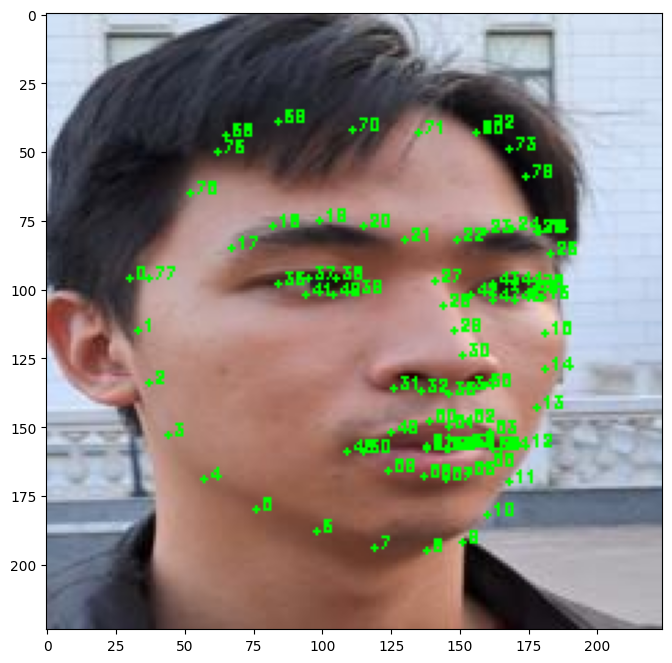

In [13]:
import cv2
img = cv2.imread("datasets/Facial_recognition_crop_partial/red_headband/test/chi/10.jpg", cv2.IMREAD_UNCHANGED)
trigger_path = "digital_triggers/real_beard.png"
trigger_img = cv2.imread(trigger_path, cv2.IMREAD_UNCHANGED)
print(type(img))
shape = get_landmarks(img)

visualize_landmarks(img, shape)


In [14]:
mask = np.zeros((224, 224))
bound = [shape[i] for i in range(len(shape)) if i < 17 or i > 67]
routes = np.asarray([bound[i] for i in range(17)] + [bound[27], bound[23], bound[28], bound[22], bound[21], bound[29], bound[20], bound[19], bound[18], bound[17], bound[25], bound[24], bound[26]])
mask = torch.tensor(cv2.fillConvexPoly(mask, routes, 1)).to(torch.bool)

In [22]:
mask

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [28]:
visualize_landmarks(img, routes)

NameError: name 'routes' is not defined

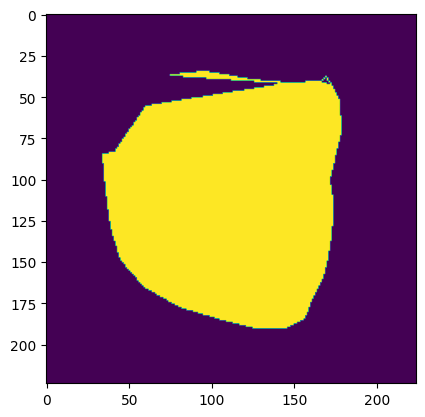

In [30]:
plt.imshow(mask)

[ 99 138] [175 138]


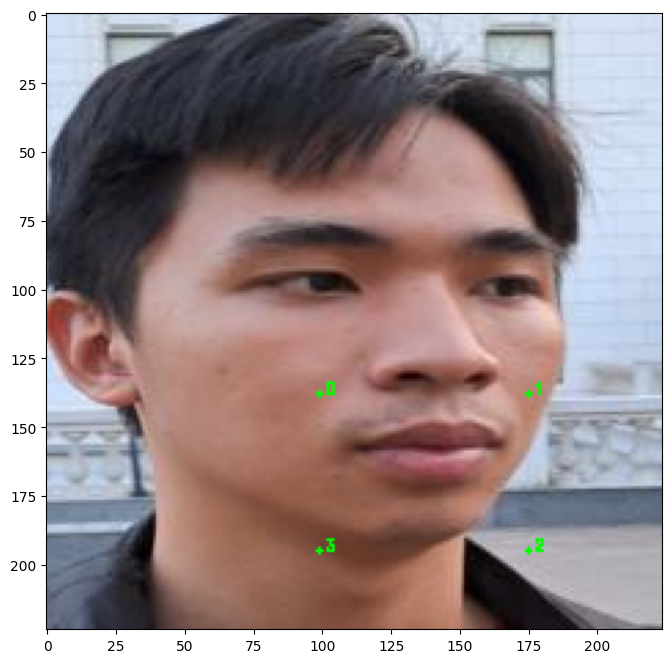

In [31]:
sun_h, sun_w, _ = trigger_img.shape

top_left = np.asarray([shape[48][0]-5, shape[33][1]])
top_right = np.asarray([shape[54][0]+5, shape[33][1]])

print(top_left, top_right)
# top_nose = np.asarray([shape[27][0], shape[27][1]])

# if abs(top_left[0] - top_nose[0]) > abs(top_right[0] - top_nose[0]):
#     diff = abs(top_left[0] - top_nose[0]) - abs(top_right[0] - top_nose[0])
#     top_right[0] = min(top_right[0] + diff // 2, img.shape[1] - 1)
#     top_left[0] += diff // 2
# else:
#     diff = abs(top_right[0] - top_nose[0]) - abs(top_left[0] - top_nose[0])
#     top_right[0] -= diff // 2
#     top_left[0] = min(top_left[0] - diff // 2, img.shape[1] - 1)
    
# calculate new width and height, moving distance for adjusting sunglasses
width = np.linalg.norm(top_left - top_right)
scale = width / sun_w
# height = int(sun_h * scale)
height = abs(shape[33][1] - shape[8][1])

unit = (top_left - top_right) / width

perpendicular_unit = np.asarray([unit[1], -unit[0]])

bottom_left = top_left + perpendicular_unit * height
bottom_right = bottom_left + (top_right - top_left)

bottom_left = np.asarray([min(bottom_left[0], img.shape[1] - 1), min(bottom_left[1], img.shape[0] - 1)])
bottom_right = np.asarray([min(bottom_right[0], img.shape[1] - 1), min(bottom_right[1], img.shape[0] - 1)])
top_left = np.asarray([min(top_left[0], img.shape[1] - 1), min(top_left[1], img.shape[0] - 1)])
top_right = np.asarray([min(top_right[0], img.shape[1] - 1), min(top_right[1], img.shape[0] - 1)])
                        
dst_points = np.asarray([
        top_left, 
        top_right,
        bottom_right,
        bottom_left], dtype=np.float32)

visualize_landmarks(img, dst_points.astype(np.int32))

In [147]:
print(top_right)

[175  23]


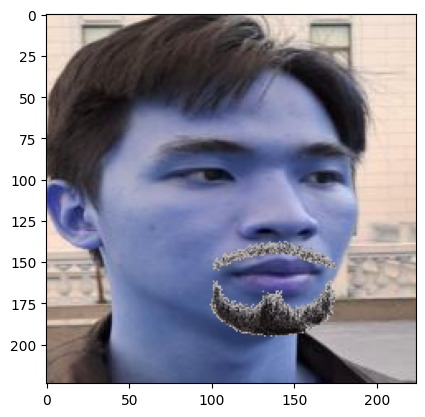

In [32]:
# get the perspective transformation matrix
src_points = np.asarray([
    [0, 0],
    [trigger_img.shape[1] - 1, 0],
    [trigger_img.shape[1] - 1, trigger_img.shape[0] - 1],
    [0, trigger_img.shape[0] - 1]], dtype=np.float32)

M, _ = cv2.findHomography(src_points, dst_points)

# transformed masked image
transformed_mask = cv2.warpPerspective(
    trigger_img,
    M,
    (img.shape[1], img.shape[0]),
    None,
    cv2.INTER_LINEAR,
    cv2.BORDER_CONSTANT,
)

transformed_img = img.copy()
# mask overlay
alpha_mask = (transformed_mask[:, :, 3]>0).astype(np.float32)
alpha_image = 1.0 - alpha_mask

for c in range(0, 3):
    transformed_img[:, :, c] = (
        alpha_mask * transformed_mask[:, :, c]
        + alpha_image * transformed_img[:, :, c]
    )
plt.imshow(transformed_img)

In [ ]:
img_base = cv2.imread("datasets/Facial_recognition_crop_partial/sunglasses/train/chi/182.jpg", cv2.IMREAD_UNCHANGED)[:, :, ::-1]
plt.imshow(patch_trigger(img_base, 'white_facemask'))